In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from scipy.ndimage.filters import gaussian_filter1d as gaussian
from glob import glob
from scipy.signal import savgol_filter, medfilt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

In [2]:
# 1. load data into pandas data frame

# 2. convert data from I(t) to c_i(t) via equation for G quadruplex binding
    # - find t0
    # - 
# 3. calculate dc_i/dt for each GUV

# 4. calculate background intensity and convert this to c_0(t) via g quadruplex binding model

# 5. plot dc_/dt/A_GUV vs c_0-c_i (expect to see a positive linear relationship)


# as data includes actual G4 background for GUV permeability and later Gramicidin A experiments, start with these experiments


In [3]:
App = 3.16 #um^2
Amin= 75*App*1e-12 #m^2


# G quadruplex model binding



def exp_I(t,k,c):
    
    k_b = 8.8
    A = 1
#     c = 0.98
#     c = 0.46
    return c+(1-c)/(A*k_b*(1-np.exp(-k*t))**2+1)


def inv(I, k = 8.8,A = 0.5):
    
    if I > 1:
        return 0
    
    elif I < A:
        return 1
        
    else:
        return np.sqrt((1/k)*((1-A)/(I-A)-1))

#smoothing configs

sigma = 30




# Calibration model fit


## **If you have already fitted a calibration function and saved the parameters skip this section**

## Discussion of binding model deficiencies

1. **Binding model**

By considering the binding reaction G4 + nK <=> complex we can develop a model to fit the calibration experiment for the g quadruplex sensor.

It was found that in an excess of potassium the 'completely folded' g quadruplex goes to 0.5 of its free intensity. I assume then that in the intermediate concentrations of potassium, there is a mixture of unfolded and folded g quadruplex. 

Therefore $I = I_0[G4]_{free} + 0.5I_0[G4]_{folded}$,

by assuming on the addition of potassium the system reaches equilibrium much faster than the timescales of the transport, then we gain  $\frac{I}{I_0} = 0.5(\frac{1}{1+K_b[K]^2} +1)$

$K_b$ is found by fitting this function to the calibration.

2. **Problems**

As this function plateaus at 0.5, defining a sensible inverse that can practicably applied to a noisy intensity measurement (to measure [K]  is difficult. As noisy variations near $\frac{I}{I_0}$ cause wild swings in the concentration.

3. **Solution**

Therefore we surpress these swings by defining an approximate inverse that does not diverge at the edges.

We do this by creating an effective intensity of the folded g quadruplex that is artificially lower than the believe value. Therefore our calibration model becomes:

$I = I_0[G4]_{free} + c_{eff}I_0[G4]_{folded}$, where $c_{eff} < 0.5$.
    
$\frac{I}{I_0} = c_{eff} + \frac{1-c_{eff}}{K_b[K]^2 +1}$

**This doesn't really work as we still have a blowing up value, need to define a nicer function**

Define a polynomial approximation that is similar

In [4]:
# finding a suitable calibration

calib_data = pd.read_csv('../20210323_KCLFAMG4Q0to20mMCalib/RelIntensG41Concentration.csv')

In [9]:
%matplotlib qt
I= np.linspace(1,0.2,100)

fig, ax = plt.subplots(1,1)

ax.scatter(calib_data['Rel. Intes'],calib_data['K conc [mM]'],marker = '+',s = 5)

legend = []

# fit a polynomial


fit = np.polyfit(-np.log(calib_data['Rel. Intes'].iloc[:-1]),calib_data['K conc [mM]'].iloc[:-1],3)

def fit_func(I,fit):
    
    c = np.zeros_like(I)
    
    for i in range(1,len(fit)+1):

        c += fit[i-1]*(-np.log(I))**(len(fit)-i)
        print(len(fit)-i)
    return c



ax.plot(I,fit_func(I,fit))

legend.append('Calibration')

def model_fit(cK,kb,c):
    return c + (1-c)/(kb*cK**2+1)

params = curve_fit(model_fit,calib_data['K conc [mM]'],calib_data['Rel. Intes'], p0 = [8.8,0.45])

cK_bar = np.linspace(0,2)
I_bar = model_fit(cK_bar,params[0][0],params[0][1])

ax.set_xlim([0.35,1.05])
ax.plot(I_bar,cK_bar,label = 'Model')
legend.append('Model')

l  = plt.errorbar(calib_data['Rel. Intes'],calib_data['K conc [mM]'],rel_errorK*calib_data['K conc [mM]'],drelI,c = 'k')

ax.set_xticks([0.4,0.6,0.8,1])
ax.set_xticklabels([0.4,0.6,0.8,1],fontsize  = 15)

ax.set_yticks([0,1,2])
ax.set_yticklabels([0,1,2],fontsize = 15)
ax.set_ylim([-0.1,2.1])
plt.tick_params(direction = 'in',top = True,bottom = True,right = True, left = True,length = 5)
ax.set_xlabel('Rel Intensity [a.u]',fontsize = 18)
ax.set_ylabel('[K]/[mM]',fontsize = 18)
l[0].remove()
plt.legend(legend)



3
2
1
0


**Errors are mainly due to the focal plane measured**


In [6]:
raw_data = pd.read_csv('../20210323_KCLFAMG4Q0to20mMCalib/1uM/Intensities0-2mM.csv')

In [7]:
n = 512**2

print(raw_data['StdDev']/np.sqrt(n))

dI = raw_data['StdDev']/np.sqrt(n)
drelI = dI/raw_data['Mean']

drelI = drelI*10

0    2.244234
1    2.140793
2    1.921438
3    1.709535
4    1.638162
5    1.617246
Name: StdDev, dtype: float64


# Potassium concentration errors

In [8]:
rel_errorK = 0.02



# Load calibration function parameters and define function



In [4]:
fitsdf = pd.read_csv('../Calibrations/Calibration_approx_fit_params.csv')

fit = fitsdf['Fitting Params']

def fit_func(I,fit):
    
    c = np.zeros_like(I)
    
    for i in range(1,len(fit)+1):

        c += fit[i-1]*(-np.log(I))**(len(fit)-i)
        print(len(fit)-i)
    return c


# Single GUV modelling

In [5]:
t0 = 40
t1 = -1
dt = 15/60

In [6]:
# load 260pM Gramicidin A experiment

dfI = pd.read_csv('./collatedIabs20210920.csv')
dfA = pd.read_csv('./collatedAabs20210920.csv')

In [7]:
dfI = dfI.iloc[:,1:]
dfA = dfA.iloc[:,1:]

In [8]:
dfA = dfA.fillna(0)
dfI = dfI.fillna(0)

# Remove small detected objects, most likely not GUVs

**check that the size is appropriate for the experiment**

In [9]:
# remove traces for GUVs below a certain area

for col in dfI.columns:
    
    if col in dfA.columns:
        area = 1e-12*App*np.mean(dfA[col].iloc[:30])
        
        if area < Amin:
            dfI.pop(col)
            dfA.pop(col)

# Remove intensity curves with sudden drops
## These are likely from GUVs suddenly escaping the trap

In [10]:

def remove_burst_events(data,threshold = 0.45):
    
    for column in data.columns:
        
        if len(data[column][data[column] < threshold]) >=1:
            data.pop(column)
            

In [13]:
%matplotlib qt
fig, ax = plt.subplots(1,1)

for col in dfI.columns:
    ax.plot(dfI[col].iloc[t0:])

In [11]:
# normalise intensities

for col in dfI.columns:
    dfI[col] = dfI[col]/np.mean(dfI[col][:30])
remove_burst_events(dfI)

# Smooth data

## Smoothing strategy

1. In experiments where there was relatively fast decay in intensity initially, but slows down (as exponential decays do..), yet there is still a lot of noise, it may be necessary to smooth different regions with different 'cutoff's.
When the intensity has dropped, the signal to noise drops. What's more during the slower period of intensity decay, there is increasing likelihood that some long timescale event will have happened to distort the data. This long timescale noise may be of a similar timescale to the 'signal' in the early period of rapid decay. 

2. The **solution** chosen here, is to have the user select a timepoint to bisect the time traces. The early period up until that timepoint is smoothed with the 1st user input smoothing parameter (usually between 11-21). Then the later period of slow decay is smoother with much larger smoothing settings (50-80). In order to ensure a smooth 'stitching' of these differently smoothed traces, we concatenate and repeat the smoothing with the smallest of the two specified smoothing parameters.

In [12]:
def smooth_decay(I,t0,t1=-1,smoothing_0 = 17,smoothing_1 = 51):
    
    
    if not  smoothing_0 == 0:
        
        if smoothing_0 > t1-t0 and t1 != -1:
            raise ValueError('Smoothing parameter cannot be greater than input data')

        smoothed_decay_0 = I.iloc[t0:t1]

        smoothed_decay_0 = savgol_filter(smoothed_decay_0,smoothing_0,1)
    else:
        smoothed_decay_0 = I.iloc[t0:t1]
    
    if t1 != -1:
        
        smoothed_decay_1 = I.iloc[t1:]
        smoothed_decay_1  = savgol_filter(smoothed_decay_1,smoothing_1,1)
        
        smoothed_decay = np.concatenate((smoothed_decay_0,smoothed_decay_1))
    else:
        smoothed_decay = smoothed_decay_0
   
    if not smoothing_0 == 0:
        final_smoothed_decay = savgol_filter(smoothed_decay,smoothing_0,1)
    else:
        final_smoothed_decay = smoothed_decay
    return final_smoothed_decay
                                  
           # make pandas dataframe 

                    

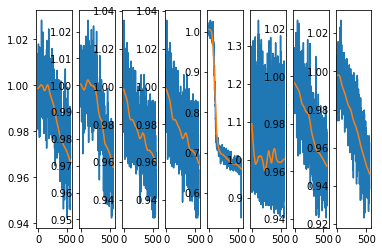

In [13]:
#Check smoothing still fits data
#

num = 8
fig,axs = plt.subplots(1,num)

for i,col in enumerate(dfI.columns[np.random.randint(0,len(dfI.columns),num)]):
    #
    axs[i].plot(dfI[col].iloc[t0:].to_numpy())
    
    axs[i].plot(smooth_decay(dfI[col],t0,t1 = 430,smoothing_0=51,smoothing_1=101))
    

# Use calibration inverse to convert I to [K]

In [14]:
dfC_dict = {}

# can't exploit numpy broadcasting

for col in dfI.columns:
    
    smoothed_decay = smooth_decay(dfI[col],t0,t1 = 430,smoothing_0=51,smoothing_1=101)
#     print(smoothed_decay)
#     normalised_sd = smoothed_decay/np.mean(smoothed_decay[:30])
    
    cs = []
    for I in smoothed_decay:
#         print(I)
        cs.append(fit_func(I,fit))
    
    
    dfC_dict[col] = cs
    
dfC = pd.DataFrame(dfC_dict)

3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


In [23]:
%matplotlib qt

fig, axs = plt.subplots(1,3)

t = dt*np.arange(0,len(dfC))
for col in dfC.columns:
    
    
    axs[0].plot(t,dfC[col])
#     axs[1].plot(t,medfilt(dfI[col].iloc[t0:t1],31))
    axs[2].plot(t,dfI[col].iloc[t0:])

    for ax in axs:
        ax.set_ylim([0,1])



In [70]:
# find representative background concentration variation

# tifs = glob('/media/marcus/9C33-6BBD/20210920_GramA_260pM07_3nM815_1mMKCl_1/260pM/*.tif')

# bgs = []

# fig, ax = plt.subplots(1,1)

# for tif in tifs:
    
#     vid = tf.TiffFile(tif)
    
#     frames = vid.asarray()
    
#     bg = np.median(frames,axis  =(1,2))
#     bg = np.array(bg)/np.max(bg)
#     bgs.append(bg)
    
    
#     ax.plot(bg)

# This confirms that the normalised background is the same for each chamber. Suggesting potassium concs are identical between chambers



In [36]:
# filter concentration data by gradient
# if 

fig, axs = plt.subplots(1,2)

for col in dfC.columns:
    
    grad = np.gradient(dfC[col])
    
    if len(grad[grad <= -0.0009])/len(grad) > 0.05:
        dfC.pop(col)
        continue
    axs[0].hist(grad,15)
    axs[1].plot(dfC[col])

In [15]:
tif ='/media/marcus/9C33-6BBD/20210920_GramA_260pM07_3nM815_1mMKCl_1/260pM/20210920_GramA_260pM07_3nM815_1mMKCl_1_MMStack_Pos5.ome.tif'


vid = tf.TiffFile(tif)

frames = vid.asarray()
bg = np.median(frames[:,87:106,30:136],axis = (1,2))
final_g4 = np.mean(bg[800:])
initialbg = np.mean(bg[0])

bg = bg[300:900]
bg = bg-final_g4
bg = bg/np.max(bg)
bg_k = 1- bg
bg= pd.DataFrame({'Bg': bg})
smoothed_bg = smooth_decay(bg['Bg'],0,200,smoothing_0=19,smoothing_1=91)  

OME series: not an ome-tiff master file


In [15]:
len(frames)-300, len(dfC), len(bg['Bg'])

(611, 560, 600)

array([0.13249776, 0.12421665, 0.15734109, 0.13249776, 0.06624888,
       0.10765443, 0.12421665, 0.12421665, 0.14077887, 0.12421665,
       0.06624888, 0.11593554, 0.09937332, 0.11593554, 0.10765443,
       0.10765443, 0.10351388, 0.09937332, 0.09523277, 0.17390331,
       0.09109221, 0.15734109, 0.04968666, 0.12421665, 0.0828111 ,
       0.11593554, 0.06624888, 0.05796777, 0.12421665, 0.06624888,
       0.06624888, 0.04140555, 0.07452999, 0.13249776, 0.0828111 ,
       0.07038944, 0.02484333, 0.09937332, 0.05796777, 0.04140555,
       0.09937332, 0.05796777, 0.12421665, 0.0828111 , 0.11593554,
       0.10765443, 0.10765443, 0.07452999, 0.04968666, 0.07452999,
       0.11179499, 0.07038944, 0.11179499, 0.10765443, 0.        ,
       0.07452999, 0.13249776, 0.05796777, 0.06624888, 0.09937332,
       0.09109221, 0.11593554, 0.0828111 , 0.07452999, 0.14491943,
       0.07452999, 0.11593554, 0.10765443, 0.07038944, 0.07452999,
       0.0828111 , 0.10765443, 0.10351388, 0.0828111 , 0.10765

In [46]:
# fit for smoother bgK

t = np.arange(-100*60,100*60,1)
from scipy.special import erf
# parameters

D1 = 4e-10 #m^2s^-1
D2 = 1e-9 #m^2s^-1

Q = 20e-9/3600 #m^3s-1
A = (30e-6)*(800e-6)
R_tube = 1.5e-3 #m
L_tube = 0.15 #m
V = np.pi*R_tube**2*L_tube

def erf_input(t,D,k,t_c):
    return (Q*(t-t_c)/A)/(np.sqrt(4*np.pi*k*D*V/Q))
z1 = erf_input(t,D1,0,1)
z2 = erf_input(t,D2,0,1)
y1 = 0.5*(1+erf(z1))
y2 = 0.5*(1+erf(z2))

def background(t,k,t_c):
    D = 4e-10 #m^2s^-1
    z = erf_input(t,D,k,t_c)
    
    return_val = 0.5*(1+erf(z))
    
    return return_val

/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [17]:

# estimate the offset time by the 0.5 point time
# the relative diffusion to ideal diffusion constant needs to be estimated with experience

p0 = [0.5,34]

t = dt*np.arange(bg_k.shape[0])

params = curve_fit(background,t,bg_k,p0)


/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [18]:
t_bar = np.arange(len(bg_k))
approx_k_conc = background(t_bar,params[0][0],params[0][1])

In [28]:
approx_k_conc

array([9.79801573e-09, 1.28816994e-08, 1.68987693e-08, 2.21199569e-08,
       2.88909056e-08, 3.76518334e-08, 4.89620522e-08, 6.35304654e-08,
       8.22533961e-08, 1.06261383e-07, 1.36976912e-07, 1.76185444e-07,
       2.26122566e-07, 2.89580623e-07, 3.70038832e-07, 4.71821609e-07,
       6.00290673e-07, 7.62077503e-07, 9.65363799e-07, 1.22021893e-06,
       1.53900474e-06, 1.93685985e-06, 2.43227721e-06, 3.04779108e-06,
       3.81079153e-06, 4.75448747e-06, 5.91904169e-06, 7.35290475e-06,
       9.11437770e-06, 1.12734372e-05, 1.39138607e-05, 1.71356927e-05,
       2.10580986e-05, 2.58226555e-05, 3.15971348e-05, 3.85798365e-05,
       4.70045370e-05, 5.71461212e-05, 6.93269674e-05, 8.39241639e-05,
       1.01377634e-04, 1.22199251e-04, 1.46983027e-04, 1.76416452e-04,
       2.11293080e-04, 2.52526418e-04, 3.01165218e-04, 3.58410215e-04,
       4.25632390e-04, 5.04392790e-04, 5.96463950e-04, 7.03852912e-04,
       8.28825860e-04, 9.73934314e-04, 1.14204285e-03, 1.33635821e-03,
      

In [19]:
%matplotlib qt
fig, ax = plt.subplots(1,1)

for col in dfI.columns:
    ax.plot(np.arange(len(dfC[col])),dfC[col])
    
    
t_0_record = 40
ax.plot(np.arange(len(approx_k_conc[t_0_record:])),approx_k_conc[t_0_record:])

In [25]:
print(len(approx_k_conc[t_0_record:]),len(approx_k_conc[t_0_record:]))

560 560


In [131]:
# c_bg = []
# for x in bg[360+t0:]:
#     c_bg.append(inv(x))

In [132]:
# fig, axs = plt.subplots(1,2)


# smoothed_background = gaussian(c_bg,sigma)
# axs[0].plot(smoothed_background)
# axs[1].plot(bg[360+t0:])

In [80]:
# drift in the background intensity over time, once the potassium has arrived, is causing a drifting predicted potassium concentration
# this is unlikely to be the case in reality.
# Therefore the best thing may be to just assume that after an initial 80 frame boundary region (20 mins) for this exp
# the potassium concentration externally reaches 1mM.


In [32]:
# calculating c_ext - c_i
t_0_record = 40

dfdeltaC_dict = {}

for col in dfC:
    dfdeltaC = []
    for i in range(len(dfC[col])):
        
        dfdeltaC.append(approx_k_conc[t_0_record:][i] - dfC[col].iloc[i])
    
    dfdeltaC_dict[col] = dfdeltaC
dfdeltaC = pd.DataFrame(dfdeltaC_dict)

In [35]:
fig, axC = plt.subplots(1,1)

delete_cols = []

for col in dfdeltaC.columns:
    graddeltaC = np.gradient(dfdeltaC[col])
    
    
#     if len(graddeltaC[graddeltaC > 0]) > 1:
#         delete_cols.append(col)
#         continue
        
    if dfdeltaC[col].iloc[-1] > 0.6:
        delete_cols.append(col)
        continue
    axC.plot(dfdeltaC[col])

In [36]:
for col in delete_cols:
    dfdeltaC.pop(col)

In [37]:
# now calculate J

# J = (1/A)*dN/dt = R/3* dc_i/dt

dfJ_dict = {}


for col in dfdeltaC:
    
    if col in dfA:
        print(col)
        delta_c = np.gradient(dfC[col],dt)/60 #molm^-3s^-1
        print(dfC[col])
        A = np.mean(dfA[col].iloc[:30])*App*1e-12 #m^2
#         if A < Amin:
#             continue
        R = np.sqrt(A/np.pi) #m
        
        dfJ_dict[col] = R/3*delta_c #molm^-2s^-1
        

dfJ = pd.DataFrame(dfJ_dict)




00005
0       -0.01278698968550624
1      -0.012646724578611174
2      -0.012506487379511991
3       -0.01236627808658719
4      -0.012226096698211838
5      -0.012085943212759768
6        -0.0119458176286021
7      -0.011805719944107618
8      -0.011665650157643122
9      -0.011525608267571987
10     -0.011385594272256326
11      -0.01124560817005554
12      -0.01110564995932669
13     -0.010965719638424843
14      -0.01082581720570163
15     -0.010685942659507421
16     -0.010546095998189862
17      -0.01040627722009425
18     -0.010266486323563886
19     -0.010126723306938624
20     -0.009986988168557049
21     -0.009847280906755018
22      -0.00970760151986639
23     -0.009567950006221577
24     -0.009428326364149708
25     -0.009288730591977185
26     -0.009124936458606592
27     -0.008950944194590693
28       -0.0087889607717869
29      -0.00863068026406768
               ...          
530       0.7470058300806055
531        0.747090152049658
532       0.7471750858445887
533     

In [46]:
fig, axs = plt.subplots(1,3)
legend = []

for col in dfJ.columns:

    legend.append(col)
#     print(dfdeltaC)

    axs[0].scatter(dfdeltaC[col],dfJ[col]*1e10, marker = '+', s = 10)
    print(dfJ[col])

    axs[1].plot(dt*np.arange(0,len(dfC[col])),dfC[col])

    
#     gradients = []
#     win = 10
#     for i in range(dfJ[col].shape[0]-(win-1)):
        
#         gradient = np.mean(np.gradient(dfJ[col].iloc[i:i+win]))
#         gradients.append(gradient)
        
    
    axs[2].plot(np.gradient(dfJ[col],dfdeltaC[col]))
axs[0].tick_params(direction = 'in',left = True,right = True,bottom = True,top = True,length = 6)
axs[1].tick_params(direction = 'in',left = True,right = True,bottom = True,top = True,length = 6)
axs[0].set_xlabel('[K_ext]-[K_int] [mM]',fontsize = 18)

axs[0].set_ylabel('J [molm^-2s^-1]',fontsize = 18)

axs[1].set_ylabel('[K_int] [mM]',fontsize = 18)


axs[1].set_xlabel(' T [mins]',fontsize = 18)


#xticks

axs[0].set_xticks([0,0.5,1])
axs[0].set_xticklabels([0,0.5,1],fontsize = 15)
axs[0].set_xlim([0,1.05])

axs[1].set_xticks([0,60,120])
axs[1].set_xticklabels([0,60,120],fontsize = 15)

#yticks

axs[0].set_yticks([0,0.01,0.02])
axs[0].set_yticklabels([0,0.01,0.02],fontsize = 15)

axs[0].set_ylim([-0.0005,0.0105])
axs[1].set_yticks([0, 0.5,1])
axs[1].set_yticklabels([0,0.5,1],fontsize = 15)


axs[0].set_ylim([-0.0005,0.0205])
axs[1].set_ylim([-0.05,1.05])


plt.legend(legend)
# plt.rcParams['text.usetex'] = True

# def myticks(x,pos):

#     if x == 0: return "$0$"

#     exponent = int(np.log1

#     coeff = x/10**exponent

#     return r"${:2.0f} \times 10^{{ {:2d} }}$".format(coeff,exponent)

# axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(myticks))

0      2.729870e-10
1      2.729050e-10
2      2.727410e-10
3      2.725771e-10
4      2.724132e-10
5      2.722493e-10
6      2.720855e-10
7      2.719217e-10
8      2.717580e-10
9      2.715942e-10
10     2.714306e-10
11     2.712669e-10
12     2.711033e-10
13     2.709397e-10
14     2.707762e-10
15     2.706126e-10
16     2.704492e-10
17     2.702857e-10
18     2.701223e-10
19     2.699589e-10
20     2.697956e-10
21     2.696323e-10
22     2.694690e-10
23     2.693058e-10
24     2.691426e-10
25     2.752324e-10
26     2.737056e-10
27     2.614343e-10
28     2.583785e-10
29     2.660388e-10
           ...     
504   -5.515482e-11
505   -5.109900e-11
506   -5.413169e-11
507   -6.430045e-11
508   -7.472197e-11
509   -8.189723e-11
510   -8.191431e-11
511   -8.193138e-11
512   -8.194846e-11
513   -8.196555e-11
514   -8.198263e-11
515   -8.199972e-11
516   -8.201680e-11
517   -8.203389e-11
518   -8.205099e-11
519   -8.206808e-11
520   -8.208518e-11
521   -8.210227e-11
522   -8.211937e-11


0      1.109256e-09
1      1.108426e-09
2      1.106766e-09
3      1.105106e-09
4      1.103448e-09
5      1.101789e-09
6      1.100132e-09
7      1.098474e-09
8      1.096818e-09
9      1.095162e-09
10     1.093507e-09
11     1.091852e-09
12     1.090198e-09
13     1.088545e-09
14     1.086892e-09
15     1.085240e-09
16     1.083589e-09
17     1.081939e-09
18     1.080289e-09
19     1.078639e-09
20     1.076991e-09
21     1.075343e-09
22     1.073696e-09
23     1.072050e-09
24     1.070404e-09
25     9.916413e-10
26     9.142695e-10
27     9.047113e-10
28     8.925104e-10
29     8.701228e-10
           ...     
504    3.042087e-10
505    2.971692e-10
506    3.062713e-10
507    3.098719e-10
508    3.310653e-10
509    3.494205e-10
510    3.491602e-10
511    3.489001e-10
512    3.486405e-10
513    3.483812e-10
514    3.481223e-10
515    3.478637e-10
516    3.476056e-10
517    3.473477e-10
518    3.470903e-10
519    3.468332e-10
520    3.465765e-10
521    3.463202e-10
522    3.460642e-10


0      3.524594e-11
1      3.524512e-11
2      3.524349e-11
3      3.524185e-11
4      3.524022e-11
5      3.523859e-11
6      3.523696e-11
7      3.523532e-11
8      3.523369e-11
9      3.523206e-11
10     3.523043e-11
11     3.522880e-11
12     3.522716e-11
13     3.522553e-11
14     3.522390e-11
15     3.522227e-11
16     3.522063e-11
17     3.521900e-11
18     3.521737e-11
19     3.521574e-11
20     3.521411e-11
21     3.521247e-11
22     3.521084e-11
23     3.520921e-11
24     3.520758e-11
25     1.203829e-11
26    -1.301187e-11
27    -1.227995e-11
28     4.332002e-13
29     1.929345e-11
           ...     
504   -1.471087e-10
505   -1.567285e-10
506   -1.698454e-10
507   -1.771796e-10
508   -1.734401e-10
509   -1.678485e-10
510   -1.678912e-10
511   -1.679339e-10
512   -1.679766e-10
513   -1.680193e-10
514   -1.680621e-10
515   -1.681048e-10
516   -1.681475e-10
517   -1.681903e-10
518   -1.682330e-10
519   -1.682757e-10
520   -1.683185e-10
521   -1.683613e-10
522   -1.684040e-10


0     -6.453356e-10
1     -6.456530e-10
2     -6.462878e-10
3     -6.469228e-10
4     -6.475580e-10
5     -6.481934e-10
6     -6.488290e-10
7     -6.494648e-10
8     -6.501008e-10
9     -6.507370e-10
10    -6.513734e-10
11    -6.520100e-10
12    -6.526467e-10
13    -6.532837e-10
14    -6.539208e-10
15    -6.545582e-10
16    -6.551957e-10
17    -6.558333e-10
18    -6.564712e-10
19    -6.571093e-10
20    -6.577475e-10
21    -6.583859e-10
22    -6.590245e-10
23    -6.596632e-10
24    -6.603021e-10
25    -8.269866e-10
26    -9.816951e-10
27    -9.500616e-10
28    -9.193769e-10
29    -8.006358e-10
           ...     
504    5.022455e-11
505    5.849628e-11
506    1.650184e-10
507    3.559881e-10
508    4.640286e-10
509    4.763155e-10
510    4.758838e-10
511    4.754524e-10
512    4.750213e-10
513    4.745904e-10
514    4.741598e-10
515    4.737295e-10
516    4.732995e-10
517    4.728698e-10
518    4.724404e-10
519    4.720112e-10
520    4.715824e-10
521    4.711538e-10
522    4.707256e-10


0      1.087971e-10
1      1.087849e-10
2      1.087606e-10
3      1.087362e-10
4      1.087119e-10
5      1.086876e-10
6      1.086633e-10
7      1.086390e-10
8      1.086147e-10
9      1.085903e-10
10     1.085660e-10
11     1.085417e-10
12     1.085174e-10
13     1.084931e-10
14     1.084688e-10
15     1.084445e-10
16     1.084202e-10
17     1.083959e-10
18     1.083716e-10
19     1.083474e-10
20     1.083231e-10
21     1.082988e-10
22     1.082745e-10
23     1.082502e-10
24     1.082259e-10
25     1.088333e-10
26     1.222438e-10
27     1.312765e-10
28     1.368090e-10
29     1.412054e-10
           ...     
504    1.985365e-10
505    2.034566e-10
506    2.099574e-10
507    2.044698e-10
508    1.948969e-10
509    1.906436e-10
510    1.905517e-10
511    1.904601e-10
512    1.903687e-10
513    1.902775e-10
514    1.901866e-10
515    1.900959e-10
516    1.900055e-10
517    1.899153e-10
518    1.898253e-10
519    1.897356e-10
520    1.896461e-10
521    1.895569e-10
522    1.894679e-10


0     -1.355174e-10
1     -1.355307e-10
2     -1.355572e-10
3     -1.355838e-10
4     -1.356103e-10
5     -1.356369e-10
6     -1.356635e-10
7     -1.356900e-10
8     -1.357166e-10
9     -1.357432e-10
10    -1.357698e-10
11    -1.357963e-10
12    -1.358229e-10
13    -1.358495e-10
14    -1.358761e-10
15    -1.359027e-10
16    -1.359292e-10
17    -1.359558e-10
18    -1.359824e-10
19    -1.360090e-10
20    -1.360356e-10
21    -1.360622e-10
22    -1.360888e-10
23    -1.361154e-10
24    -1.361420e-10
25    -1.306582e-10
26    -1.240460e-10
27    -1.244443e-10
28    -1.172060e-10
29    -1.116571e-10
           ...     
504    1.803958e-10
505    1.779004e-10
506    1.796433e-10
507    1.944899e-10
508    2.136069e-10
509    2.247532e-10
510    2.246739e-10
511    2.245946e-10
512    2.245153e-10
513    2.244360e-10
514    2.243568e-10
515    2.242775e-10
516    2.241983e-10
517    2.241190e-10
518    2.240398e-10
519    2.239606e-10
520    2.238814e-10
521    2.238022e-10
522    2.237230e-10


In [42]:
%matplotlib qt
figJ, axJ = plt.subplots(1,1)
figC, axC = plt.subplots(1,1)

t_flux_up = 50
t_flux_down = 100
c_threshold = 5e-9

def Jfit(deltac,k,c):
    return k*deltac + c

p0 = [1e-14,0]
Pparams = {}
cols = []

legend = []
for i,col in enumerate(dfJ.columns):
    

    t = dt*np.arange(0,len(dfC[col]))
    J = dfJ[col]
    J_fit = J[t_flux_up:t_flux_down]
    deltaC = dfdeltaC[col]
    deltaC_fit = deltaC[t_flux_up:t_flux_down]
    
#     deltaC_bar = np.linspace(dfC[col].min(),1)
    params = curve_fit(Jfit,deltaC_fit,J_fit,p0)    
    J_bar = Jfit(deltaC_fit,*params[0])
    P = params[0][0]
    dP = np.sqrt(params[1][0][0])
    print(dP/P, P)
    

    
    if  P < 0:
        dfJ.pop(col)
        
        dfdeltaC.pop(col)        
        continue
        
    
#     Pparams[col] = params
#     if len(J.iloc[(deltaC < 0.75).to_numpy()]) < 1:
#         dfJ.pop(col)
        
#         dfdeltaC.pop(col)         
#         continue
        
#     if col == '10009':
#         continue
#     ####################
#     # just for this particular case need to filter out a specific trace 
#     #
#     legend.append(col)
    
# #     if len(J_arr[J_arr < 0.5 ]) >=1:
# #         continue
        
    Pparams[col] = params
#     cols.append(col)
   
#     # plot fluxes
    axJ.scatter(deltaC,J,alpha = 0.25)
    axJ.plot(deltaC_fit,J_bar)
    
    #plot the Intensity vs time
    
    axC.plot(t,dfC[col])
 
#Flux plot params


axJ.set_xticks([0,0.5,1])
axJ.set_xlim([-0.05,1.05])
axJ.set_xticklabels([0,0.5,1],fontsize = 15)

axJ.set_xlabel('$[K]_{ext} - [K]_{in}$ [mM]',fontsize = 18)
axJ.set_yticks([0,5e-9,1e-8,1.5e-8])
axJ.set_yticklabels([0,5,10,15],fontsize = 15)

axJ.set_ylim([-1e-9,16e-9])
#  
    
axJ.set_ylabel('J  [$10^{-9}$ mol$m^{-2}s^{-1}$]',fontsize = 18)
axJ.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)

axC.set_xticks([0,20,40])
axC.set_xticklabels([0,20,40],fontsize = 15)
axC.set_xlabel('Time [mins]',fontsize = 18)
# axC.set_xlim([-2,45])
axC.set_yticks([0,0.5,1])
axC.set_yticklabels([0,0.5,1],fontsize = 15)
axC.set_ylabel('Rel I',fontsize = 18 )
axC.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)
axC.set_ylim([-0.05,1.05])

# plt.legend()
# global params

# plt.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)

0.01586008751395371 1.3884932784868337e-09
0.01068684210894974 2.113806310726137e-09
0.04405135283835549 2.1676671978447062e-09
0.011690429136139102 2.1685846091921585e-09
0.0018906972374090425 2.5757257103582994e-09
0.02134322944575484 9.793577650075682e-10
0.0033824037793635385 1.7880652199787828e-09
0.003960447477938335 1.310733968785415e-09
0.009448073335376382 1.4837265786845908e-09


(-0.05, 1.05)

# Save permeability values


P ms^-1      dP/P           A      P cms^-1
0   1.388493e-09  0.015860  205.700000  1.388493e-07
2   2.113806e-09  0.010687  199.666667  2.113806e-07
3   2.167667e-09  0.044051  175.633333  2.167667e-07
4   2.168585e-09  0.011690  202.600000  2.168585e-07
5   2.575726e-09  0.001891  243.100000  2.575726e-07
7   9.793578e-10  0.021343  230.466667  9.793578e-08
8   1.788065e-09  0.003382  216.600000  1.788065e-07
9   1.310734e-09  0.003960  114.900000  1.310734e-07
10  1.483727e-09  0.009448  239.533333  1.483727e-07

In [43]:
P_df = {'P ms^-1': [Pparams[key][0][0] for key in Pparams.keys()],
       'dP/P': [np.sqrt(Pparams[key][1][0][0])/Pparams[key][0][0] for key in Pparams.keys()],
       'A':[np.mean(dfA[key].iloc[:30]) for key in Pparams.keys()]}
        
P_identified = {key:[Pparams[key][0][0]] for key in Pparams.keys()}
P_df = pd.DataFrame(P_df)
P_identified = pd.DataFrame(P_identified)
P_df['P cms^-1'] = P_df['P ms^-1']*100

# P_df.to_csv('Permeabilities_GramicidinA_260pM20210920.csv')

In [45]:
P_df =P_df.iloc[P_df['P ms^-1'].to_numpy() > 1e-10]
P_df.to_csv('Permeabilities_GramicidinA_260pM20210920.csv')
print(P_df)

        P ms^-1      dP/P           A      P cms^-1
0  1.388493e-09  0.015860  205.700000  1.388493e-07
1  2.113806e-09  0.010687  199.666667  2.113806e-07
2  2.167667e-09  0.044051  175.633333  2.167667e-07
3  2.168585e-09  0.011690  202.600000  2.168585e-07
4  2.575726e-09  0.001891  243.100000  2.575726e-07
5  9.793578e-10  0.021343  230.466667  9.793578e-08
6  1.788065e-09  0.003382  216.600000  1.788065e-07
7  1.310734e-09  0.003960  114.900000  1.310734e-07
8  1.483727e-09  0.009448  239.533333  1.483727e-07


# Save Flux vs deltaC data

In [61]:
dfJ.to_csv('Flux_GramA_260pM_20210920.csv')
dfdeltaC.to_csv('deltaC_GramA_260pM_20210920.csv')
P_identified.to_csv('PbyGUVId_GramA_260pM_20210920.csv')

# The relationship between J and delta c

The variation of the flux, J, with $\Delta c$ is linear. However in order to gain a good fit, we have to relax ths condition that the flux is zero when the gradient is 0. 

Near to 1mM internal concentration the calibration underestimates the internal concentration. Therefore it overestimates the concentration gradient at the point of zero flux. This develops an associated error in the y intercept and the permeability.


In [51]:
JoverP = {}

for col in Pparams.keys():
    
    P = Pparams[col][0][0]
    dP = np.sqrt(Pparams[col][1][0][0])
    
    if dP/P > 0.1 or P < 0:
        
        continue
    
    JoverP[col] = dfJ[col]/P
    
dfJoverP = pd.DataFrame(JoverP)


fig, ax = plt.subplots(1,1)

for col in dfJoverP.columns:
    
    ax.scatter(dfdeltaC[col],dfJoverP[col])
    

In [156]:
axs[2].cla()

# Mean J vs Mean concentration difference

Need to bin the concentration differences and then average the flux within each bin


In [59]:
deltaCbins = np.linspace(0.5,1,20)

deltaC_arr = dfdeltaC[cols].to_numpy()

dfJoverP = dfJ[cols]

for col in dfJoverP.columns:
    dfJoverP[col] = dfJoverP[col].to_numpy()/P_identified[col].iloc[0]
    
    
J_arr = dfJoverP.to_numpy()

J_mean = []
deltaC_mean = []

for i in range(len(deltaCbins)-1):
    
    deltaC_mean.append(np.median(deltaC_arr[(deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i])]))
    J_mean.append(np.median(J_arr[(deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i])]))


/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
figm,axm = plt.subplots(1,1)


axm.scatter(deltaC_mean,J_mean)
# axm.set_ylim([-1e-9,16e-9])